# Dark Sky Positions direct from Catalogue

In [119]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits

import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

from dl import queryClient as qc
import pandas as pd

In [120]:
# timer function
import functools
import time

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer


## Querying tractor catalogue for one degree squares

In [121]:
@timer
def query_tractor(ra, dec, dist=1.0):
    """Queries the Astro Data Lab for the ra, dec and mag_g of the objects within a square of side length (dist).     
    dist is in degrees
    """
    # Bounds of the square we are querying objects for
    ra_min=ra
    ra_max = ra + dist
    dec_min=dec
    dec_max = dec + dist

    query = f"""
    SELECT ra, dec, mag_g
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_g <= 21 AND mag_g >= 16
    """
    
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    return brick_info

## Get bitmask info

In [122]:
@timer
def load_mask_data(index=0, load_all=False):
    """Load a desired mask data file by index, or just download all five. 
    Returns a pandas Dataframe with columns 'ra', 'dec', 'radius'
    """
    
    # load all
    if load_all:
        all_masks = []
        for i in range(5):
            
            with np.load(f"mask_data_{i}.npz", mmap_mode='r') as mask_data:
                mask_array = mask_data['arr_0']
                mask_array_byteswap = mask_array.byteswap().newbyteorder()
                masked_stars = pd.DataFrame(mask_array_byteswap)
                all_masks.append(masked_stars)
        return pd.concat(all_masks, ignore_index=True)

    # load single index
    with np.load(f"mask_data_{index}.npz", mmap_mode='r') as mask_data:
        mask_array = mask_data['arr_0']
        mask_array_byteswap = mask_array.byteswap().newbyteorder()
        masked_stars = pd.DataFrame(mask_array_byteswap)

    return masked_stars
    

## Process mask and catalog data together

In [123]:
# masking for low magnitude objects

@timer
def mask_radius(mag_g, mask_radius=20):
    return (mask_radius/3600) + 1630./3600. * 1.396**(-mag_g)

In [124]:
# combine mask and star data

@timer
def combine_data(masked_stars, catalog_stars, coords, mask_minimum):
    # coords = [ra-map_dist, ra+map_dist, dec-map_dist, dec+map_dist]
    
    # cut masked stars to only use the same area as catalog_stars
    masked_box = masked_stars.query('(@coords[0] < ra < @coords[1]) and (@coords[2] < dec < @coords[3])')
    
    # apply buffer radius to mask and star data
    masked_box['radius'] = masked_box['radius'] + (mask_minimum / 3600.)
    catalog_stars['radius'] = mask_radius(catalog_stars['mag_g'], mask_minimum)
    
    # remove g mag
    catalog_stars = catalog_stars.drop('mag_g', axis=1)
    
    # combine catalog + mask
    all_stars = pd.concat([masked_box, catalog_stars]).reset_index(drop=True)
    # all_stars
    # print(repr(all_stars))
    # print(catalog_stars.columns)
    # print(masked_stars.columns)
    
    
    # fig, ax = plt.subplots()
    # ax.plot(all_stars['ra'], all_stars['dec'], '.')
    # plt.show()
    return all_stars

In [125]:
# generate_dark_sky_catalogue(3,-4)

## Segmentation map

Start with OG seg map, without bitmask stuff yet

In [126]:
@timer
def full_df(masked_stars, tractor_df, coords):
    # coords is: tuple/array of [ra_min, ra_max, dec_min, dec_max]
    one_deg_sq = masked_stars.query(' (ra >' + str(coords[0]) + ') & (ra <' + str(coords[1]) + ') & (dec >' + str(coords[2]) + ') & (dec <' + str(coords[3]) + ')' )
    df = pd.concat([tractor_df,one_deg_sq], axis=0)
    df = df.drop('mag_g', axis=1)
    return df

## Segmentation map

In [127]:
@timer
def seg_map(df, dim, coords):
    # coords = [ra-map_dist, ra+map_dist, dec-map_dist, dec+map_dist] 

    array = np.zeros((dim, dim), dtype=int)

    ra_pix = np.round((df['ra'] - coords[0]) * dim).astype(int) - 1
    dec_pix = np.round((df['dec'] - coords[2]) * dim ).astype(int) - 1
    rad_pix = np.ceil(df['radius']*dim).astype(int)

    for y, x, r in zip(ra_pix,dec_pix,rad_pix):
        ra_max = x + r if x+r <= dim else dim
        ra_min = x - r if x-r >= 0 else 0
        dec_max = y + r if y+r <= dim else dim
        dec_min = y - r if y-r >= 0 else 0

        for i in range(ra_min,ra_max):
            for j in range(dec_min,dec_max):
                if ((i-x)**2 + (j-y)**2) <= r**2:
                    array[i,j] = 1

    return array, [ra_pix, dec_pix, rad_pix]

In [128]:
@timer
def define_grid(dim, fov=45):
    gridlines = np.arange(0, dim+1, (fov/3600 * dim))
    return gridlines

In [129]:
@timer
def find_dark_regions(array, gridlines):

    # calculating and storing the centre of each dark coord
    centers = []

    for i in range(len(gridlines[:-1])):
        centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

    x_cen, y_cen = np.meshgrid(centers, centers)

    dark_regions = []

    for i in range(len(gridlines) - 1):
        for j in range(len(gridlines) - 1):
            x_start, x_end = (gridlines[i]).astype(int), (gridlines[i + 1]).astype(int)
            y_start, y_end = (gridlines[j]).astype(int), (gridlines[j + 1]).astype(int)
            
            if np.all(array[y_start:y_end, x_start:x_end] == 0):
                dark_regions.append([x_cen[j, i], y_cen[j, i]])

    dr_trans = np.array(dark_regions).transpose()

    return dr_trans, dark_regions

In [130]:
@timer
def create_plot(array, coords, pix_coords, gridlines, dim, dr_trans):

    # Creating exclusion map with grid
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.imshow(array, origin = 'lower', cmap='gray', vmin=0, vmax=1)

    positions = np.linspace(0,dim,5)
    x_labels = np.linspace(coords[0],coords[1],5)
    y_labels = np.linspace(coords[2],coords[3],5)

    ax.set_xticks(positions, x_labels)
    ax.set_yticks(positions, y_labels)    

    plt.vlines(gridlines, min(pix_coords[1]), max(pix_coords[1]), color='red', linewidth=1)
    plt.hlines(gridlines, min(pix_coords[0]), max(pix_coords[0]), color= 'red', linewidth=1)

    plt.plot(dr_trans[0], dr_trans[1], 'rx', markersize=10)

    plt.tight_layout()
    plt.margins(0)
    plt.show()

    return

In [131]:
@timer
def create_data_frame(dark_regions, coords, dim):
    dark_ra = []
    dark_dec = []

    for i in dark_regions:
        ra = i[0] / (dim) + coords[0]
        dec = i[1] / (dim) + coords[2]
        dark_ra.append(ra)
        dark_dec.append(dec)

    dark_catalogue = pd.DataFrame({'ra':dark_ra, 'dec':dark_dec})
    return dark_catalogue

In [132]:
@timer
def generate_dark_sky_catalogue(ra, dec, query_dist=1.0, map_dist=1.0, mask_min_radius=20, fov=45):
    """Generates a dataframe of RA/DEC pairs corresponding to allowed dark positions
    
    Parameters
    ----------
    ra: `float`
        starting right ascension to query/analyze from (degrees)
    dec: `float`
        starting declination to query/analyze from (degrees)
    query_dist: `float`
        length of one side of the queried square region of sky from starting ra/dec (degrees, default=1)
    map_dist: `float`
        length of one side of the analyzed square region of sky from starting ra/dec (degrees, default=1)
    mask_min_radius: `float`
        minimum masking radius for detected objects (arcseconds, default=20)
    fov: `float`
        minimum spacing between dark sky regions (arcseconds, default=45)
    """
    
    dim = int((3600*4) * map_dist)
    
    # load masked data
    print("Loading masked star data....")
    masked_stars = load_mask_data(load_all=True)
    
    print(f"Querying the tractor catalog for stars from RA({ra}, {ra+query_dist}) to DEC({dec}, {dec+query_dist})...")
    tractor_df = query_tractor(ra, dec, query_dist)
    
    # concatenate data
    coords = [ra, ra+map_dist, dec, dec+map_dist]
    all_stars = combine_data(masked_stars, tractor_df, coords, mask_min_radius)

    # return
    # print("Calculating masking radii for catalog stars....")
    # tractor_df = mask_radius(tractor_df, mask_min_radius)
    
    # print("Combining mask and queried stars...")
    
    # df = full_df(masked_stars, tractor_df, coords)

    print("Creating segmentation map...")
    array, pix_coords = seg_map(all_stars, dim, coords)

    print("Defining grid lines...")
    gridlines = define_grid(dim, fov)

    print("Finding dark regions...")
    dr_trans, dark_regions = find_dark_regions(array, gridlines)

    print("Plotting dark regions...")
    create_plot(array, coords, pix_coords, gridlines, dim, dr_trans)

    print("Converting dark regions to coordinates...")
    dark_catalogue = create_data_frame(dark_regions, coords, dim)
    
    print("Done!")

    return dark_catalogue

Loading masked star data....
Elapsed time: 2.6007 seconds
Querying the tractor catalog for stars from RA(3, 4.0) to DEC(-4, -3.0)...
Elapsed time: 7.5280 seconds


/tmp/ipykernel_13204/3767367203.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_box['radius'] = masked_box['radius'] + (mask_minimum / 3600.)


Elapsed time: 0.0006 seconds
Elapsed time: 0.2894 seconds
Creating segmentation map...
Elapsed time: 61.6846 seconds
Defining grid lines...
Elapsed time: 0.0000 seconds
Finding dark regions...
Elapsed time: 0.3478 seconds
Plotting dark regions...


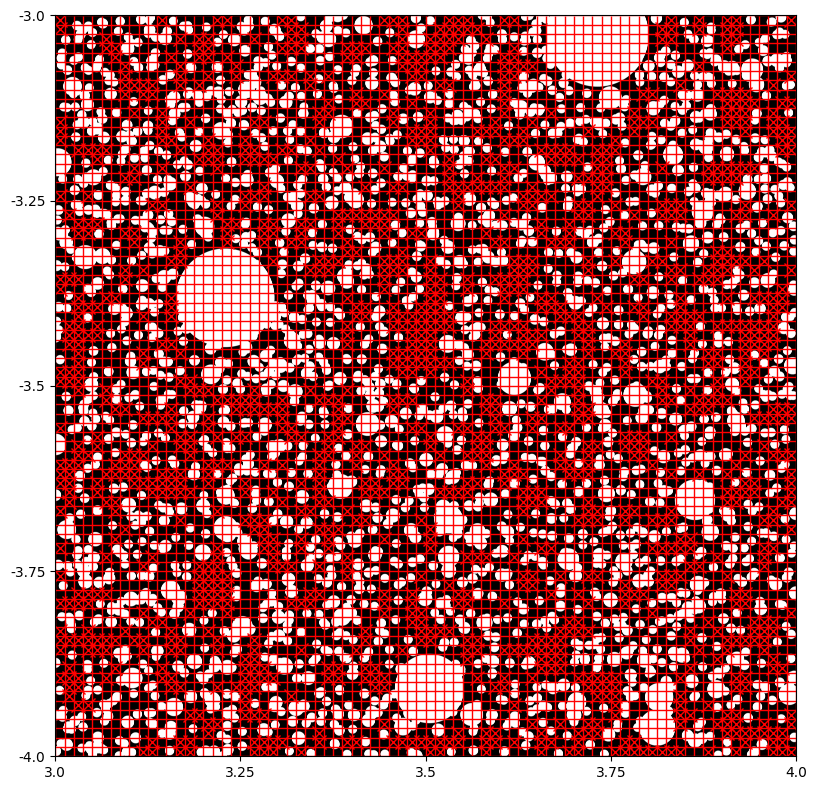

Elapsed time: 5.1077 seconds
Converting dark regions to coordinates...
Elapsed time: 0.0009 seconds
Done!
Elapsed time: 77.5631 seconds


,ra,dec
0,3.00625,-3.89375
1,3.00625,-3.85625
2,3.00625,-3.84375
3,3.00625,-3.83125
4,3.00625,-3.79375
...,...,...
1307,3.99375,-3.16875
1308,3.99375,-3.15625
1309,3.99375,-3.11875
1310,3.99375,-3.08125


In [133]:
generate_dark_sky_catalogue(3,-4)